In [82]:
import os
import sys
import pandas as pd
from sklearn import datasets
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from IPython.display import display, HTML
from sklearn.datasets import load_iris
from pystout import pystout
import matplotlib.pyplot as plt
import numpy as np

In [83]:
# Global Settings
pd.set_option("display.float_format", lambda x: "%.4f" % x)

In [84]:
cwd = os.getcwd()
# Find and import config file
config_path = os.getcwd()

sys.path.append(config_path)
import config

database = config.database
central_banks = config.central_banks
training_data = os.path.join(database, "Training Data")
fed_docs = config.fed_docs
ecb_docs = config.ecb_docs
boe_docs = config.boe_docs

In [85]:
test = pd.read_csv(
    "/Users/kylenabors/Documents/Database/Models/FinBERT Models/taylor.csv"
)

In [86]:
sentiment = pd.date_range(start="1/1/1990", end="12/31/2024", freq="D")
sentiment = pd.DataFrame(sentiment, columns=["date"])

In [87]:
# Import inflation probability data that is stored as a dta file
inflation_prob_us = pd.read_stata(
    "/Users/kylenabors/Documents/Database/Other Data/Inflation Probabilities/USwestimates.dta"
)

inflation_prob_us = inflation_prob_us.rename(columns={"date_ym": "date"})

inflation_prob_eu = pd.read_stata(
    "/Users/kylenabors/Documents/Database/Other Data/Inflation Probabilities/EZwestimates.dta"
)

inflation_prob_eu = inflation_prob_eu.rename(columns={"date_ym": "date"})

inflation_prob = inflation_prob_us.merge(
    inflation_prob_eu, on="date", how="left", suffixes=("_us", "_eu")
)

sentiment = sentiment.merge(inflation_prob, on="date", how="left")

# sentiment = sentiment.ffill()

In [88]:
inflation_diff = pd.read_excel(
    "/Users/kylenabors/Documents/Database/Market Data/Inflation/12m cumulative inflation.xlsx"
)

print(inflation_diff.dtypes)

sentiment = pd.merge(sentiment, inflation_diff, on="date", how="left")

date               datetime64[ns]
12m_inf                   float64
target_distance           float64
high_inf                  float64
low_inf                   float64
dtype: object


In [89]:
indexes = pd.read_excel(
    "/Users/kylenabors/Documents/Database/Other Data/Indexes/five_indexes.xlsx"
)
indexes["date"] = pd.to_datetime(indexes["date"])
sentiment = pd.merge(sentiment, indexes, how="left", left_on="date", right_on="date")

In [90]:
market = pd.read_csv(f"{database}/Market Data/All Market Data.csv")
market = market.rename(columns={"PCE": "pce", "GDP": "gdp", "GDPPOT": "gdp_pot"})
market["date"] = pd.to_datetime(market["date"])

sentiment = pd.merge(sentiment, market, how="left", left_on="date", right_on="date")

In [91]:
# # HP Filter

url_map = pd.read_csv(os.path.join(cwd, "url_map.csv"))

for i in range(len(url_map)):
    temp_dates = pd.date_range(start="1/1/1990", end="12/31/2024", freq="D")
    temp_dates = pd.DataFrame(temp_dates, columns=["date"])
    sent = pd.read_csv(url_map["finbert_url"][i])
    sent = sent[["date", "sentiment"]]

    sent["date"] = pd.to_datetime(sent["date"])
    sent = sent.groupby("date").mean().reset_index()

    sent = pd.merge(temp_dates, sent, how="left", left_on="date", right_on="date")

    # Set 'date' as the index for resampling
    sent.set_index("date", inplace=True)

    sent["sentiment"] = sent["sentiment"].ffill()

    # Resample to quarterly frequency
    sent = sent.resample("Q").mean()

    # Drop NaNs
    sent = sent.dropna(subset=["sentiment"])

    # Reset index to turn 'date' back into a column
    sent.reset_index(inplace=True)

    filter_df = sent.copy(deep=True)

    cycle, trend = sm.tsa.filters.hpfilter(filter_df["sentiment"], 1600)

    filter_df["sentiment_cycle"] = cycle
    filter_df["sentiment_trend"] = trend

    filter_df = filter_df[["date", "sentiment_cycle"]]
    sent = sent.drop(columns=["sentiment"])
    filter_df = filter_df.rename(columns={"sentiment_cycle": "sentiment"})
    sent = pd.merge(sent, filter_df, on="date", how="outer")
    sent = sent.groupby("date").mean().reset_index()

    sent = sent.rename(columns={"sentiment": url_map["document"][i]})
    sentiment = pd.merge(sentiment, sent, how="outer", left_on="date", right_on="date")

In [92]:
# url_map = pd.read_csv(os.path.join(cwd, "url_map.csv"))

# for i in range(len(url_map)):
#     sent = pd.read_csv(url_map["finbert_url"][i])
#     sent = sent[["date", "sentiment"]]

#     sent = sent.rename(columns={"sentiment": url_map["document"][i]})
#     sentiment = pd.merge(sentiment, sent, how="outer", left_on="date", right_on="date")

In [93]:
fedfunds = pd.read_csv(
    "/Users/kylenabors/Documents/Database/Market Data/Fed Funds/Fed Funds.csv"
)
fedfunds["date"] = pd.to_datetime(fedfunds["date"])
sentiment = pd.merge(sentiment, fedfunds, how="left", left_on="date", right_on="date")

In [94]:
stocks = sentiment.copy(deep=True)
stocks = stocks[["date", "sp500_return", "stoxx"]]
stocks["log_returns"] = np.log(1 + stocks["sp500_return"])
stocks["log_returns_eu"] = np.log(1 + stocks["stoxx"])
stocks = stocks.resample("Q", on="date").sum().reset_index()

for i in range(0, 6):
    stocks[f"log_returns_{i}"] = stocks["log_returns"].shift(i)
    stocks[f"log_returns_eu_{i}"] = stocks["log_returns_eu"].shift(i)

In [95]:
# Resample the final 'sentiment' DataFrame to quarterly frequency
sentiment = sentiment.drop(columns=["sp500_return", "stoxx"])
sentiment = sentiment.resample("Q", on="date").mean().reset_index()

In [96]:
# Create lagged columns
for column in sentiment.columns:
    if column != "date":  # Skip the 'date' column
        sentiment[f"{column}_1"] = sentiment[column].shift(1)

for i in range(1, 5):
    sentiment[f"fed_minutes_forward_{i}"] = sentiment["fed_minutes"].shift(-i)
    sentiment[f"press_conferences_forward_{i}"] = sentiment["press_conferences"].shift(
        -i
    )

In [97]:
sentiment = pd.merge(sentiment, stocks, how="left", left_on="date", right_on="date")

In [98]:
# sentiment = sentiment[
#     (sentiment["date"] >= "2000-01-01") & (sentiment["date"] <= "2023-01-30")
# ]

sentiment = sentiment[
    (sentiment["date"] >= "2000-01-01") & (sentiment["date"] <= "2022-06-30")
]

In [99]:
# Export sentiment as csv
sentiment.to_csv(f"{database}/Sentiment.csv", index=False)

In [100]:
print(sentiment.columns)

Index(['date', 'date_stata_us', 'higher4_5y5y_us', 'higher5_5y5y_us',
       'lower0_5y5y_us', 'lowerm1_5y5y_us', 'zc_higher4_5y_us',
       'zc_higher5_5y_us', 'zc_lower0_5y_us', 'zc_lowerm1_5y_us',
       ...
       'log_returns_1', 'log_returns_eu_1', 'log_returns_2',
       'log_returns_eu_2', 'log_returns_3', 'log_returns_eu_3',
       'log_returns_4', 'log_returns_eu_4', 'log_returns_5',
       'log_returns_eu_5'],
      dtype='object', length=161)


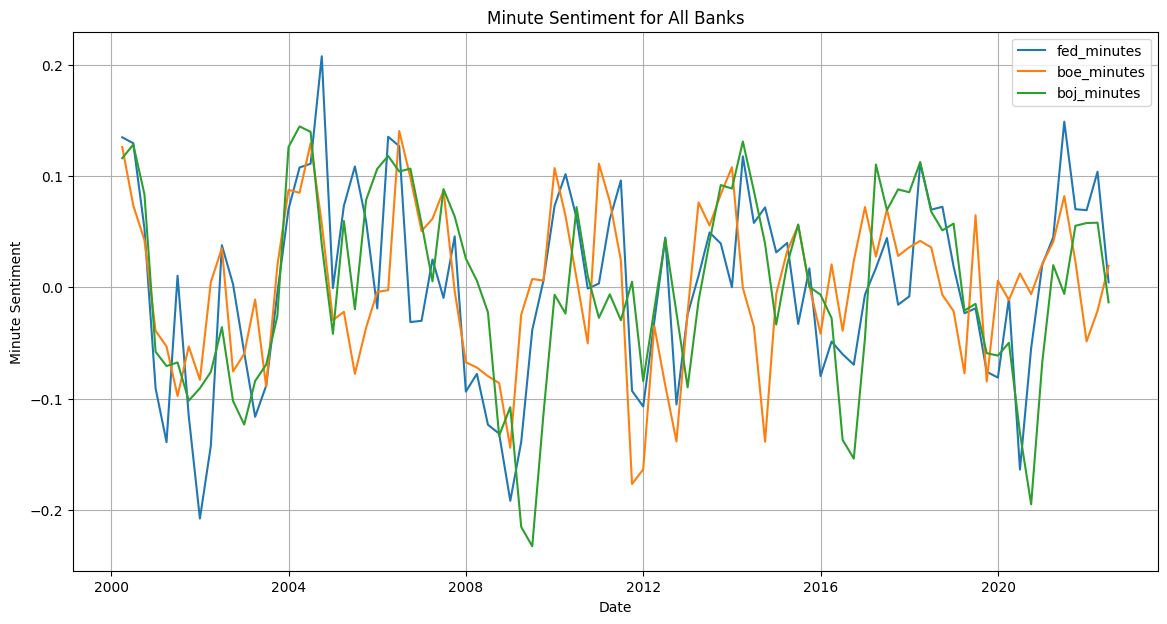

In [ ]:
import matplotlib.pyplot as plt

# List of columns containing minute sentiment for all banks
minute_sentiment_columns = [
    "fed_minutes",
    "ecb_minutes",
    "boe_minutes",
    "boj_minutes",
    "boa_minutes",
    "boc_minutes",
    "boswiss_minutes",
    "bosweaden",
]

# Plotting the minute sentiment for all banks
plt.figure(figsize=(14, 7))

for column in minute_sentiment_columns:
    if column in sentiment.columns:
        plt.plot(sentiment["date"], sentiment[column], label=column)

plt.xlabel("Date")
plt.ylabel("Minute Sentiment")
plt.title("Minute Sentiment for All Banks")
plt.legend()
plt.grid(True)
plt.show()

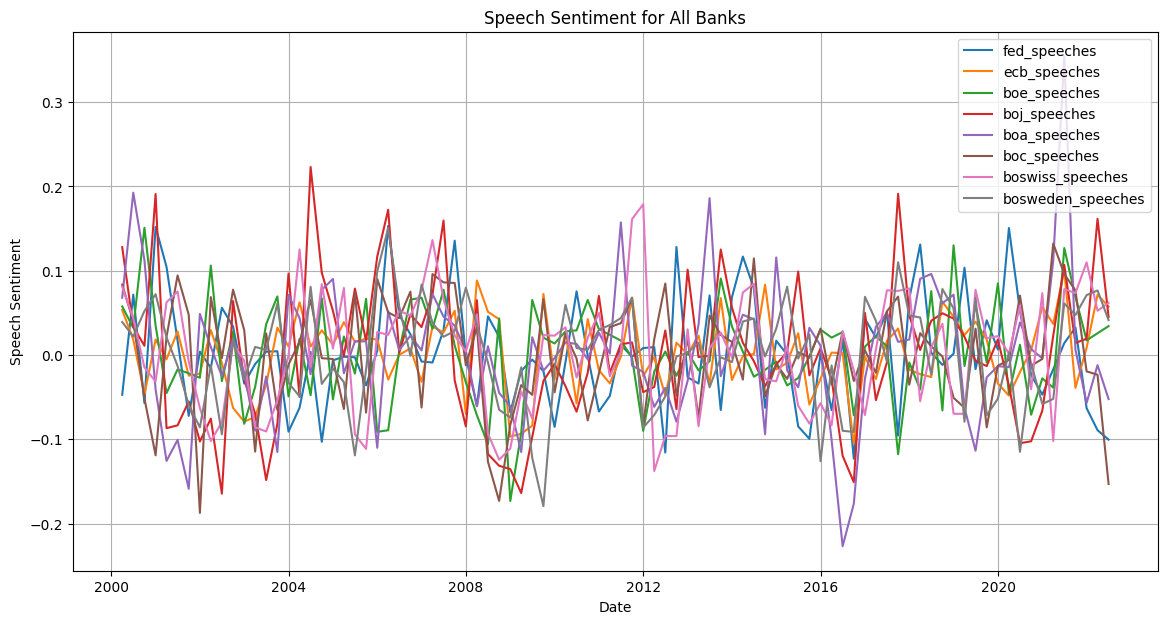

In [ ]:
import matplotlib.pyplot as plt

# List of columns containing speech sentiment for all banks
speech_sentiment_columns = [
    'fed_speeches', 'ecb_speeches', 'boe_speeches', 'boj_speeches', 'boa_speeches', 'boc_speeches', 'boswiss_speeches', 'bosweden_speeches',
]

# Plotting the speech sentiment for all banks
plt.figure(figsize=(14, 7))

for column in speech_sentiment_columns:
    if column in sentiment.columns:
        plt.plot(sentiment['date'], sentiment[column], label=column)

plt.xlabel('Date')
plt.ylabel('Speech Sentiment')
plt.title('Speech Sentiment for All Banks')
plt.legend()
plt.grid(True)
plt.show()

In [102]:
# Table 3 Pt. 1

x = [
    "press_conferences",
    "press_conferences_1",
    "fed_minutes_1",
]

yvar0 = "fed_minutes"
yvar1 = "fed_minutes_forward_1"
yvar2 = "fed_minutes_forward_2"
yvar3 = "fed_minutes_forward_3"
yvar4 = "fed_minutes_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Fed Minute Sentiment Regressed on Financial Variables")
stargazer.custom_columns(
    [
        "Fed Sent. (t)",
        "Fed Sent. (t+1)",
        "Fed Sent. (t+2)",
        "Fed Sent. (t+3)",
        "Fed Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "press_conferences",
        "press_conferences_1",
        "fed_minutes_1",
    ]
)

stargazer.rename_covariates(
    {
        "press_conferences": "ECB Sent (t)",
        "press_conferences_1": "ECB Sent (t-1)",
        "fed_minutes_1": "Fed Sent (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Fed Minute Sentiment Regressed on Financial Variables}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed Sent. (t)} & \multicolumn{1}{c}{Fed Sent. (t+1)} & \multicolumn{1}{c}{Fed Sent. (t+2)} & \multicolumn{1}{c}{Fed Sent. (t+3)} & \multicolumn{1}{c}{Fed Sent. (t+4)}  \\
\hline \
 ECB Sent (t) & 0.289$^{***}$ & 0.316$^{***}$ & 0.109$^{}$ & 0.037$^{}$ & -0.150$^{*}$ \\
& (0.087) & (0.084) & (0.082) & (0.085) & (0.090) \\
 ECB Sent (t-1) & -0.152$^{*}$ & -0.317$^{***}$ & -0.331$^{***}$ & -0.432$^{***}$ & -0.254$^{***}$ \\
& (0.090) & (0.083) & (0.081) & (0.094) & (0.092) \\
 Fed Sent (t-1) & 0.537$^{***}$ & 0.318$^{***}$ & 0.295$^{***}$ & 0.283$^{***}$ & 0.060$^{}$ \\
& (0.097) & (0.096) & (0.104) & (0.094) & (0.098) \\
\hline \
 Observations & 90 & 90 & 90 & 90 & 90 \\
 $R^2$ & 0.412 & 0.200 & 0.132 & 0.222 & 0.191 \\
 Adjusted $R^2$ & 0.392 & 0.172 & 0.102 & 0.195 & 0.163 \\
 Residual Std. Error & 0.066 (df=86

In [103]:
# Table 3 Pt. 2

x = [
    "fed_minutes",
    "fed_minutes_1",
    "press_conferences_1",
]

yvar0 = "press_conferences"
yvar1 = "press_conferences_forward_1"
yvar2 = "press_conferences_forward_2"
yvar3 = "press_conferences_forward_3"
yvar4 = "press_conferences_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Fed Minute Sentiment Regressed on Financial Variables")
stargazer.custom_columns(
    [
        "ECB Sent. (t)",
        "ECB Sent. (t+1)",
        "ECB Sent. (t+2)",
        "ECB Sent. (t+3)",
        "ECB Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "fed_minutes",
        "fed_minutes_1",
        "press_conferences_1",
    ]
)

stargazer.rename_covariates(
    {
        "fed_minutes": "Fed Sent (t)",
        "fed_minutes_1": "Fed Sent (t-1)",
        "press_conferences_1": "ECB Sent (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Fed Minute Sentiment Regressed on Financial Variables}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{ECB Sent. (t)} & \multicolumn{1}{c}{ECB Sent. (t+1)} & \multicolumn{1}{c}{ECB Sent. (t+2)} & \multicolumn{1}{c}{ECB Sent. (t+3)} & \multicolumn{1}{c}{ECB Sent. (t+4)}  \\
\hline \
 Fed Sent (t) & 0.419$^{***}$ & 0.266$^{*}$ & 0.208$^{}$ & 0.281$^{**}$ & 0.106$^{}$ \\
& (0.132) & (0.158) & (0.140) & (0.142) & (0.161) \\
 Fed Sent (t-1) & -0.146$^{}$ & 0.058$^{}$ & 0.124$^{}$ & 0.017$^{}$ & 0.216$^{}$ \\
& (0.128) & (0.157) & (0.162) & (0.170) & (0.144) \\
 ECB Sent (t-1) & 0.573$^{***}$ & 0.205$^{**}$ & 0.081$^{}$ & -0.048$^{}$ & -0.225$^{**}$ \\
& (0.072) & (0.104) & (0.107) & (0.121) & (0.114) \\
\hline \
 Observations & 90 & 90 & 90 & 90 & 90 \\
 $R^2$ & 0.450 & 0.140 & 0.083 & 0.054 & 0.065 \\
 Adjusted $R^2$ & 0.431 & 0.110 & 0.051 & 0.021 & 0.033 \\
 Residual Std. Error & 0.079 (df=86) & 0.096 (df=86) & 0.

In [104]:
# # Define the independent variables for each regression
# x = ["fed_minutes", "fed_minutes_1", "fedfunds_1"]

# yvar0 = "fedfunds"
# yvar1 = "fedfunds_forward_1"
# yvar2 = "fedfunds_forward_2"
# yvar3 = "fedfunds_forward_3"
# yvar4 = "fedfunds_forward_4"


# # Prepare the exogenous variables for each regression
# exog0 = sm.add_constant(sentiment[x]).dropna()
# exog1 = sm.add_constant(sentiment[x]).dropna()
# exog2 = sm.add_constant(sentiment[x]).dropna()
# exog3 = sm.add_constant(sentiment[x]).dropna()
# exog4 = sm.add_constant(sentiment[x]).dropna()


# # Fit the regression models
# reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
# reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
# reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
# reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
# reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# # Create the Stargazer object
# stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# # Customize the Stargazer output
# stargazer.show_model_numbers(False)
# stargazer.significant_digits(3)

# # Display the Stargazer output
# display(HTML(stargazer.render_html()))
# print(stargazer.render_latex())

In [105]:
# Fed SR LR ECB SR LR

x0 = [
    "higher4_5y5y_us",
    "higher4_5y5y_us_1",
    "lower0_5y5y_us",
    "lower0_5y5y_us_1",
    "fed_minutes_1",
]

x1 = [
    "zc_higher4_5y_us",
    "zc_higher4_5y_us_1",
    "zc_lower0_5y_us",
    "zc_lower0_5y_us_1",
    "fed_minutes_1",
]

x2 = [
    "higher4_5y5y_eu",
    "higher4_5y5y_eu_1",
    "lower0_5y5y_eu",
    "lower0_5y5y_eu_1",
    "press_conferences_1",
]

x3 = [
    "zc_higher4_5y_eu",
    "zc_higher4_5y_eu_1",
    "zc_lower0_5y_eu",
    "zc_lower0_5y_eu_1",
    "press_conferences_1",
]


yvar = "fed_minutes"
yvar1 = "fed_minutes"
yvar2 = "press_conferences"
yvar3 = "press_conferences"

exog0 = (sm.add_constant(sentiment[x0])).dropna()
exog1 = (sm.add_constant(sentiment[x1])).dropna()
exog2 = (sm.add_constant(sentiment[x2])).dropna()
exog3 = (sm.add_constant(sentiment[x3])).dropna()

reg0 = sm.OLS(endog=sentiment[yvar].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")

stargazer = Stargazer([reg0, reg1, reg2, reg3])
stargazer.title(
    "Regressing Fed Sentiment on SP500 Returns and Regressing ECB Sentiment on STOXX 600 Returns"
)
stargazer.custom_columns(["SR Fed(t)", "LR Fed(t)", "SR ECB(t)", "LR ECB(t)"])
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)
stargazer.covariate_order(
    [
        "higher4_5y5y_us",
        "higher4_5y5y_us_1",
        "lower0_5y5y_us",
        "lower0_5y5y_us_1",
        "zc_higher4_5y_us",
        "zc_higher4_5y_us_1",
        "zc_lower0_5y_us",
        "zc_lower0_5y_us_1",
        "higher4_5y5y_eu",
        "higher4_5y5y_eu_1",
        "lower0_5y5y_eu",
        "lower0_5y5y_eu_1",
        "zc_higher4_5y_eu",
        "zc_higher4_5y_eu_1",
        "zc_lower0_5y_eu",
        "zc_lower0_5y_eu_1",
        "fed_minutes_1",
        "press_conferences_1",
    ]
)
stargazer.rename_covariates(
    {
        "higher4_5y5y_us": "Inflation(t)",
        "higher4_5y5y_us_1": "Inflation(t-1)",
        "lower0_5y5y_us": "Deflation(t)",
        "lower0_5y5y_us_1": "Deflation(t-1)",
        "zc_higher4_5y_us": "Inflation(t)",
        "zc_higher4_5y_us_1": "Inflation(t-1)",
        "zc_lower0_5y_us": "Deflation(t)",
        "zc_lower0_5y_us_1": "Deflation(t-1)",
        "higher4_5y5y_eu": "Inflation(t)",
        "higher4_5y5y_eu_1": "Inflation(t-1)",
        "lower0_5y5y_eu": "Deflation(t)",
        "lower0_5y5y_eu_1": "Deflation(t-1)",
        "zc_higher4_5y_eu": "Inflation(t)",
        "zc_higher4_5y_eu_1": "Inflation(t-1)",
        "zc_lower0_5y_eu": "Deflation(t)",
        "zc_lower0_5y_eu_1": "Deflation(t)",
        "fed_minutes_1": "Fed(t-1)",
        "press_conferences_1": "ECB(t-1)",
    },
)
stargazer.add_custom_notes(
    [
        "The unit for t is the time between a given meeting and the previous meeting for the given Central Bank."
    ]
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Regressing Fed Sentiment on SP500 Returns and Regressing ECB Sentiment on STOXX 600 Returns}
\begin{tabular}{@{\extracolsep{5pt}}lcccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{SR Fed(t)} & \multicolumn{1}{c}{LR Fed(t)} & \multicolumn{1}{c}{SR ECB(t)} & \multicolumn{1}{c}{LR ECB(t)}  \\
\hline \
 Inflation(t) & 0.111$^{}$ & & & \\
& (0.618) & & & \\
 Inflation(t-1) & 0.556$^{}$ & & & \\
& (0.593) & & & \\
 Deflation(t) & -2.111$^{***}$ & & & \\
& (0.599) & & & \\
 Deflation(t-1) & 0.712$^{}$ & & & \\
& (0.587) & & & \\
 Inflation(t) & & 0.484$^{}$ & & \\
& & (0.401) & & \\
 Inflation(t-1) & & -0.510$^{}$ & & \\
& & (0.476) & & \\
 Deflation(t) & & -2.667$^{***}$ & & \\
& & (0.489) & & \\
 Deflation(t-1) & & 1.811$^{***}$ & & \\
& & (0.529) & & \\
 Inflation(t) & & & -0.644$^{}$ & \\
& & & (1.004) & \\
 Inflation(t-1) & & & -0.297$^{}$ & \\
& & & (1.002) & \\
 Deflation(t) & & & -0.910$^{*}$ & \\
& & & (0.543) & \\
 Deflation(t-1) & & & 0.086$^{}$ &

In [106]:
# Fed SR LR ECB SR LR

x0 = [
    "higher4_5y5y_us",
    "higher4_5y5y_us_1",
    "lower0_5y5y_us",
    "lower0_5y5y_us_1",
    "fed_minutes_1",
    "log_returns_0",
    "log_returns_1",
    "log_returns_2",
    "log_returns_3",
    "log_returns_4",
    "log_returns_5",
    "12m_inf",
    "12m_inf_1",
]

x1 = [
    "zc_higher4_5y_us",
    "zc_higher4_5y_us_1",
    "zc_lower0_5y_us",
    "zc_lower0_5y_us_1",
    "fed_minutes_1",
    "log_returns_0",
    "log_returns_1",
    "log_returns_2",
    "log_returns_3",
    "log_returns_4",
    "log_returns_5",
    "12m_inf",
    "12m_inf_1",
]

x2 = [
    "higher4_5y5y_eu",
    "higher4_5y5y_eu_1",
    "lower0_5y5y_eu",
    "lower0_5y5y_eu_1",
    "press_conferences_1",
    "log_returns_eu_0",
    "log_returns_eu_1",
    "log_returns_eu_2",
    "log_returns_eu_3",
    "log_returns_eu_4",
    "log_returns_eu_5",
]

x3 = [
    "zc_higher4_5y_eu",
    "zc_higher4_5y_eu_1",
    "zc_lower0_5y_eu",
    "zc_lower0_5y_eu_1",
    "press_conferences_1",
    "log_returns_eu_0",
    "log_returns_eu_1",
    "log_returns_eu_2",
    "log_returns_eu_3",
    "log_returns_eu_4",
    "log_returns_eu_5",
]


yvar = "fed_minutes"
yvar1 = "fed_minutes"
yvar2 = "press_conferences"
yvar3 = "press_conferences"

exog0 = (sm.add_constant(sentiment[x0])).dropna()
exog1 = (sm.add_constant(sentiment[x1])).dropna()
exog2 = (sm.add_constant(sentiment[x2])).dropna()
exog3 = (sm.add_constant(sentiment[x3])).dropna()

reg0 = sm.OLS(endog=sentiment[yvar].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")

stargazer = Stargazer([reg0, reg1, reg2, reg3])
stargazer.title(
    "Regressing Fed Sentiment on SP500 Returns and Regressing ECB Sentiment on STOXX 600 Returns"
)
stargazer.custom_columns(["Fed(t)", "Fed(t)", "ECB(t)", "ECB(t)"])
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)
stargazer.covariate_order(
    [
        "12m_inf",
        "12m_inf_1",
        "higher4_5y5y_us",
        "higher4_5y5y_us_1",
        "lower0_5y5y_us",
        "lower0_5y5y_us_1",
        "zc_higher4_5y_us",
        "zc_higher4_5y_us_1",
        "zc_lower0_5y_us",
        "zc_lower0_5y_us_1",
        "higher4_5y5y_eu",
        "higher4_5y5y_eu_1",
        "lower0_5y5y_eu",
        "lower0_5y5y_eu_1",
        "zc_higher4_5y_eu",
        "zc_higher4_5y_eu_1",
        "zc_lower0_5y_eu",
        "zc_lower0_5y_eu_1",
        "log_returns_0",
        "log_returns_1",
        "log_returns_2",
        "log_returns_3",
        "log_returns_4",
        "log_returns_5",
        "log_returns_eu_0",
        "log_returns_eu_1",
        "log_returns_eu_2",
        "log_returns_eu_3",
        "log_returns_eu_4",
        "log_returns_eu_5",
        "fed_minutes_1",
        "press_conferences_1",
    ]
)
stargazer.rename_covariates(
    {
        "12m_inf": "Inflation(t)",
        "12m_inf_1": "Inflation(t-1)",
        "higher4_5y5y_us": "Inflation Proj. SR(t)",
        "higher4_5y5y_us_1": "Inflation Proj. SR(t-1)",
        "lower0_5y5y_us": "Deflation Proj. SR(t)",
        "lower0_5y5y_us_1": "Deflation Proj. SR(t-1)",
        "zc_higher4_5y_us": "Inflation Proj. LR(t)",
        "zc_higher4_5y_us_1": "Inflation Proj. LR(t-1)",
        "zc_lower0_5y_us": "Deflation Proj. LR(t)",
        "zc_lower0_5y_us_1": "Deflation Proj. LR(t-1)",
        "higher4_5y5y_eu": "Inflation Proj. SR(t)",
        "higher4_5y5y_eu_1": "Inflation Proj. SR(t-1)",
        "lower0_5y5y_eu": "Deflation Proj. SR(t)",
        "lower0_5y5y_eu_1": "Deflation Proj. SR(t-1)",
        "zc_higher4_5y_eu": "Inflation Proj. LR(t)",
        "zc_higher4_5y_eu_1": "Inflation Proj. LR(t-1)",
        "zc_lower0_5y_eu": "Deflation Proj. LR(t)",
        "zc_lower0_5y_eu_1": "Deflation Proj. LR(t)",
        "log_returns_0": "SP00 Returns(t)",
        "log_returns_1": "SP00 Returns(t-1)",
        "log_returns_2": "SP00 Returns(t-2)",
        "log_returns_3": "SP00 Returns(t-3)",
        "log_returns_4": "SP00 Returns(t-4)",
        "log_returns_5": "SP00 Returns(t-5)",
        "fed_minutes_1": "Fed(t-1)",
        "log_returns_eu_0": "STOXX600 Returns(t)",
        "log_returns_eu_1": "STOXX600 Returns(t-1)",
        "log_returns_eu_2": "STOXX600 Returns(t-2)",
        "log_returns_eu_3": "STOXX600 Returns(t-3)",
        "log_returns_eu_4": "STOXX600 Returns(t-4)",
        "log_returns_eu_5": "STOXX600 Returns(t-5)",
        "press_conferences_1": "ECB(t-1)",
    },
)
stargazer.add_custom_notes(
    [
        "The unit for t is the time between a given meeting and the previous meeting for the given Central Bank."
    ]
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Regressing Fed Sentiment on SP500 Returns and Regressing ECB Sentiment on STOXX 600 Returns}
\begin{tabular}{@{\extracolsep{5pt}}lcccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed(t)} & \multicolumn{1}{c}{Fed(t)} & \multicolumn{1}{c}{ECB(t)} & \multicolumn{1}{c}{ECB(t)}  \\
\hline \
 Inflation(t) & 0.021$^{**}$ & -0.001$^{}$ & & \\
& (0.011) & (0.012) & & \\
 Inflation(t-1) & -0.026$^{*}$ & -0.011$^{}$ & & \\
& (0.015) & (0.012) & & \\
 Inflation Proj. SR(t) & 0.631$^{}$ & & & \\
& (0.606) & & & \\
 Inflation Proj. SR(t-1) & -0.148$^{}$ & & & \\
& (0.561) & & & \\
 Deflation Proj. SR(t) & -0.433$^{}$ & & & \\
& (0.732) & & & \\
 Deflation Proj. SR(t-1) & -0.330$^{}$ & & & \\
& (0.685) & & & \\
 Inflation Proj. LR(t) & & 0.669$^{}$ & & \\
& & (0.423) & & \\
 Inflation Proj. LR(t-1) & & -0.553$^{}$ & & \\
& & (0.367) & & \\
 Deflation Proj. LR(t) & & -1.644$^{**}$ & & \\
& & (0.670) & & \\
 Deflation Proj. LR(t-1) & & 1.172$^{}$ & & \\
& & (0.760) &

In [107]:
# Define the independent variables for each regression
x = [
    "credit",
    "credit_1",
    "equity_valuation",
    "equity_valuation_1",
    "safe_assets",
    "safe_assets_1",
    "funding",
    "funding_1",
    "volatility",
    "volatility_1",
    "fed_minutes_1",
]

yvar0 = "fed_minutes"
yvar1 = "fed_minutes_forward_1"
yvar2 = "fed_minutes_forward_2"
yvar3 = "fed_minutes_forward_3"
yvar4 = "fed_minutes_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Fed Minute Sentiment Regressed on Financial Variables")
stargazer.custom_columns(
    [
        "Fed Sent. (t)",
        "Fed Sent. (t+1)",
        "Fed Sent. (t+2)",
        "Fed Sent. (t+3)",
        "Fed Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "credit",
        "credit_1",
        "equity_valuation",
        "equity_valuation_1",
        "safe_assets",
        "safe_assets_1",
        "funding",
        "funding_1",
        "volatility",
        "volatility_1",
        "fed_minutes_1",
    ]
)

stargazer.rename_covariates(
    {
        "credit": "Credit",
        "credit_1": "Credit (t-1)",
        "equity_valuation": "Equity Valuation",
        "equity_valuation_1": "Equity Valuation (t-1)",
        "safe_assets": "Safe Assets",
        "safe_assets_1": "Safe Assets (t-1)",
        "funding": "Funding",
        "funding_1": "Funding (t-1)",
        "volatility": "Volatility",
        "volatility_1": "Volatility (t-1)",
        "fed_minutes_1": "Fed Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Fed Minute Sentiment Regressed on Financial Variables}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed Sent. (t)} & \multicolumn{1}{c}{Fed Sent. (t+1)} & \multicolumn{1}{c}{Fed Sent. (t+2)} & \multicolumn{1}{c}{Fed Sent. (t+3)} & \multicolumn{1}{c}{Fed Sent. (t+4)}  \\
\hline \
 Credit & -0.021$^{}$ & -0.057$^{***}$ & -0.060$^{**}$ & -0.011$^{}$ & -0.024$^{}$ \\
& (0.023) & (0.016) & (0.029) & (0.019) & (0.021) \\
 Credit (t-1) & -0.007$^{}$ & 0.012$^{}$ & 0.032$^{}$ & -0.005$^{}$ & -0.000$^{}$ \\
& (0.018) & (0.016) & (0.022) & (0.018) & (0.019) \\
 Equity Valuation & -0.022$^{}$ & -0.035$^{}$ & -0.026$^{}$ & -0.027$^{}$ & -0.014$^{}$ \\
& (0.030) & (0.023) & (0.037) & (0.029) & (0.032) \\
 Equity Valuation (t-1) & -0.053$^{***}$ & -0.048$^{**}$ & -0.034$^{}$ & -0.014$^{}$ & -0.029$^{}$ \\
& (0.018) & (0.024) & (0.029) & (0.033) & (0.032) \\
 Safe Assets & -0.037$^{**}$ & -0.004$^{}$ & -0.016$^{}$ & -0.020$

In [108]:
# Define the independent variables for each regression
x0 = [
    "fed_minutes",
    "fed_minutes_1",
    "credit",
    "credit_1",
    "equity_valuation",
    "equity_valuation_1",
    "safe_assets",
    "safe_assets_1",
    "funding",
    "funding_1",
    "volatility",
    "volatility_1",
    "fedfunds_1",
]

x1 = [
    "fed_minutes",
    "fed_minutes_1",
    "credit",
    "credit_1",
    "equity_valuation",
    "equity_valuation_1",
    "safe_assets",
    "safe_assets_1",
    "funding",
    "funding_1",
    "volatility",
    "volatility_1",
    "fedfunds_1",
]

x2 = [
    "fed_minutes",
    "fed_minutes_1",
    "credit",
    "credit_1",
    "equity_valuation",
    "equity_valuation_1",
    "safe_assets",
    "safe_assets_1",
    "funding",
    "funding_1",
    "volatility",
    "volatility_1",
    "fedfunds_1",
]

x3 = [
    "fed_minutes",
    "fed_minutes_1",
    "credit",
    "credit_1",
    "equity_valuation",
    "equity_valuation_1",
    "safe_assets",
    "safe_assets_1",
    "funding",
    "funding_1",
    "volatility",
    "volatility_1",
    "fedfunds_1",
]

x4 = [
    "fed_minutes",
    "fed_minutes_1",
    "credit",
    "credit_1",
    "equity_valuation",
    "equity_valuation_1",
    "safe_assets",
    "safe_assets_1",
    "funding",
    "funding_1",
    "volatility",
    "volatility_1",
    "fedfunds_1",
]


# Define the dependent variables for each regression
yvar0 = "fedfunds"
yvar1 = "fedfunds_forward_1"
yvar2 = "fedfunds_forward_2"
yvar3 = "fedfunds_forward_3"
yvar4 = "fedfunds_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x0]).dropna()
exog1 = sm.add_constant(sentiment[x1]).dropna()
exog2 = sm.add_constant(sentiment[x2]).dropna()
exog3 = sm.add_constant(sentiment[x3]).dropna()
exog4 = sm.add_constant(sentiment[x4]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

stargazer.title("Fed Minute Sentiment Regressed on US 5y5y Extreme Inflation Prob.")
stargazer.custom_columns(
    [
        "Fedfunds(t)",
        "Fedfunds(t+1)",
        "Fedfunds(t+2)",
        "Fedfunds(t+3)",
        "Fedfunds(t+4)",
    ]
)

stargazer.covariate_order(
    [
        "fed_minutes",
        "fed_minutes_1",
        "credit",
        "credit_1",
        "equity_valuation",
        "equity_valuation_1",
        "safe_assets",
        "safe_assets_1",
        "funding",
        "funding_1",
        "volatility",
        "volatility_1",
        "fedfunds_1",
    ]
)

stargazer.rename_covariates(
    {
        "fed_minutes": "Fed Minutes",
        "fed_minutes_1": "Fed Minutes (t-1)",
        "credit": "Credit",
        "credit_1": "Credit (t-1)",
        "equity_valuation": "Equity Valuation",
        "equity_valuation_1": "Equity Valuation (t-1)",
        "safe_assets": "Safe Assets",
        "safe_assets_1": "Safe Assets (t-1)",
        "funding": "Funding",
        "funding_1": "Funding (t-1)",
        "volatility": "Volatility",
        "volatility_1": "Volatility (t-1)",
        "fedfunds_1": "Fed Funds (t-1)",
    }
)

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

KeyError: "['fedfunds_1'] not in index"